### VAE implementation for domain transfer

In [1]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
import torch
import numpy as np
import scanpy as sc
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline



import torch.nn as nn

def full_block(in_features, out_features, p_drop):
        return nn.Sequential(
            nn.Linear(in_features, out_features, bias=True),
            nn.LayerNorm(out_features),
            nn.ELU(),
            nn.Dropout(p=p_drop),
        )

class encoder(nn.Module):
    def __init__(self, x_dim, hid_dim=64, z_dim=64, 
                 p_drop=0):
        super(encoder, self).__init__()
        self.z_dim = z_dim
        
        self.encoder = nn.Sequential(
            full_block(x_dim, hid_dim, p_drop),
            full_block(hid_dim, z_dim, p_drop),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        return encoded  
    
class decoder(nn.Module):
    def __init__(self, y_dim, hid_dim=64, z_dim=64, 
                 p_drop=0):
        super(decoder, self).__init__()
        self.z_dim = z_dim
        
        self.decoder = nn.Sequential(
            full_block(z_dim, hid_dim, p_drop),
            full_block(hid_dim, y_dim, p_drop),
        )
        
    def forward(self, x):
        decoded = self.decoder(x)
        return decoded  
    
class VAE(pl.LightningModule):
    def __init__(self, input_dim=50, y_dim=512, 
                 enc_out_dim=512, latent_dim=256):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = encoder(input_dim, latent_dim, enc_out_dim)
        self.decoder = decoder(y_dim, enc_out_dim, latent_dim)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-5)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum()
        #return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, y = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, y)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = vae.transform(batch[0])
        
        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, y)
        
        return recon_loss
    
    def transform(self, x):
        """
        Performs multi modal domain alignment after training
        """
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)
        
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()
    
        # decoded 
        x_hat = vae.decoder(z)
        return x_hat
        
class multimodal(Dataset):
    def __init__(self, gex1, atac):
        
        self.gex1 = torch.Tensor(gex1.X.toarray())
        self.atac = torch.Tensor(atac.X.toarray())

    def __len__(self):
        return self.gex1.shape[0]

    def __getitem__(self, idx):
        return self.gex1[idx], self.atac[idx]
    


### Read in data and create dataloader

In [3]:
print("Setting up dataloaders")

# Gene Expression Dataset 1 (GEX1)
gex1 = sc.read_h5ad('../multiome/multiome_gex_processed_training.h5ad')

# DNA Accessibility Dataset (ATAC)
atac = sc.read_h5ad('../multiome/multiome_atac_processed_training.h5ad')

idx = np.arange(len(gex1))
trainval, test_idx = train_test_split(idx, test_size=0.10, shuffle=True)
train_idx, val_idx = train_test_split(trainval, test_size=0.10, shuffle=True)

gex1_train = gex1[train_idx]
gex1_val = gex1[val_idx]
gex1_test = gex1[test_idx]

atac_train = atac[train_idx]
atac_val = atac[val_idx]
atac_test = atac[test_idx]

train_dl = DataLoader(multimodal(gex1_train, atac_train), batch_size=64, shuffle=False)
val_dl = DataLoader(multimodal(gex1_val, atac_val), batch_size=64, shuffle=False)
test_dl = DataLoader(multimodal(gex1_test, atac_test), batch_size=64, shuffle=False)

Setting up dataloaders


### Train model

In [5]:
pl.seed_everything(1234)

vae = VAE(input_dim=gex1.shape[1], y_dim=atac.shape[1])

print("Dataloaders created")
"""
trainer = pl.Trainer(gpus=1, max_epochs=50, progress_bar_refresh_rate=10,
                    default_root_dir='./checkpoints/')

trainer.fit(vae, train_dl, val_dl)
"""

Global seed set to 1234


Dataloaders created


"\ntrainer = pl.Trainer(gpus=1, max_epochs=50, progress_bar_refresh_rate=10,\n                    default_root_dir='./checkpoints/')\n\ntrainer.fit(vae, train_dl, val_dl)\n"

### Load pre-trained model

In [6]:
vae = vae.load_from_checkpoint('/dfs/user/yhr/cs236_opsca/notebooks/checkpoints/lightning_logs/version_3/checkpoints/epoch=999-step=284999.ckpt')

In [7]:
preds = []

for it, batch in enumerate(test_dl):
    print(it)
    out = vae.transform(batch[0])
    preds.extend(out.detach().cpu().numpy())
    
preds = np.stack(preds)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [8]:
test_idx

array([ 4838,  5529,  9990, ...,  1403, 19684,  2894])

In [9]:
# First convert data matrix into Scanpy Anndata object
pred_adata = sc.AnnData(preds)

# Then add metadata labels for coloring the plot
# First for the model prediction
if len(pred_adata) != len(atac):
    # Subsetting to match the same size as the training set
    pred_adata.obs = atac.obs.iloc[test_idx]
else:
    pred_adata.obs = atac.obs

# Then for the true value
if len(pred_adata) != len(atac):
    true_adata = atac[test_idx]
    true_adata.obs = atac.obs.iloc[test_idx]
else:
    true_adata = atac

In [10]:
sc.pp.neighbors(pred_adata)
sc.pp.neighbors(true_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.
         Falling back to preprocessing with `sc.pp.pca` and default params.


In [51]:
error = (pred_adata.X-true_adata.X.toarray())**2
#rmse = np.sqrt(np.mean(error**2))
mean_error = error.mean(1)
true_adata.obs['mean_error']=mean_error

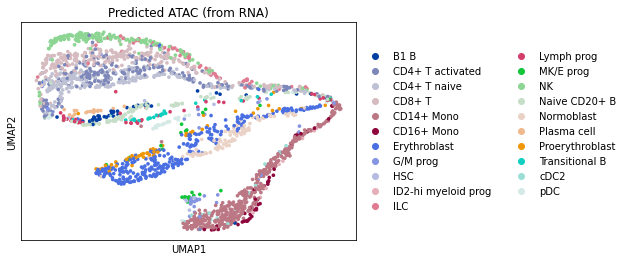

In [29]:
#sc.tl.umap(pred_adata)
sc.pl.umap(pred_adata, color=['cell_type'], title='Predicted ATAC (from RNA)')

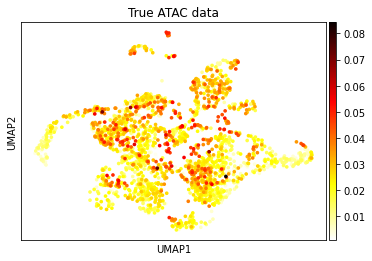

In [55]:
#sc.tl.umap(true_adata)
sc.pl.umap(true_adata, color=['mean_error'], title='True ATAC data', 
           legend_loc=None, cmap='hot_r')

In [93]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [106]:
true_adata.obs['root_mean_error'] = true_adata.obs['mean_error'].apply(np.sqrt)

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
plot_df = true_adata.obs.groupby('cell_type').mean()
plot_df = plot_df.reset_index()
plot_df = plot_df.sort_values('mean_error')

/dfs/user/yhr/deepsnap/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


(0.05, 0.2)

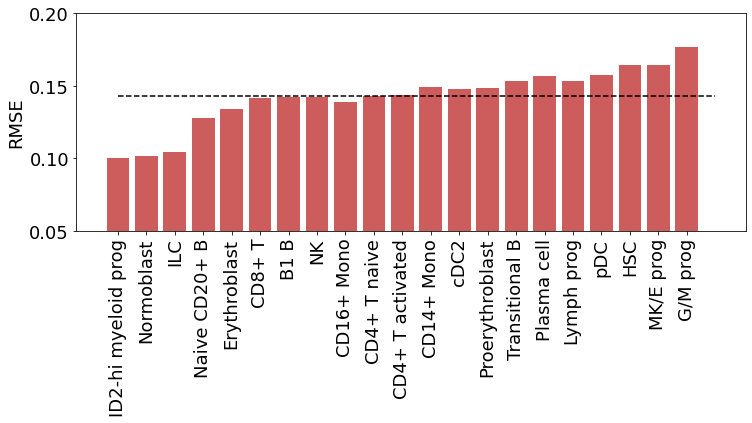

In [120]:
plt.figure(figsize=[12,4])
plt.bar(height=plot_df['root_mean_error'].values,
        x=plot_df['cell_type'].values, color='indianred')
ax = plt.gca()
_ = ax.set_xticklabels(plot_df['cell_type'].values, rotation = 90)
plt.ylabel('RMSE')
plt.plot([0,len(plot_df)], [0.143,0.143], linestyle='--', color='k')
plt.ylim([0.05,0.2])

### Old Results

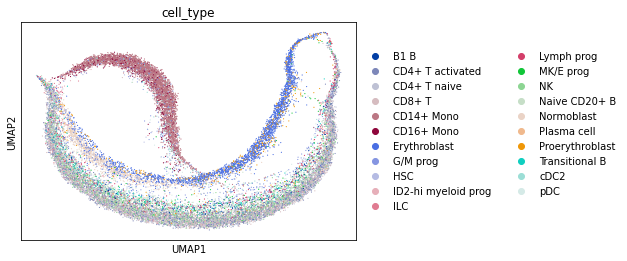

In [74]:
sc.tl.umap(pred_adata)
sc.pl.umap(pred_adata, color=['cell_type'])

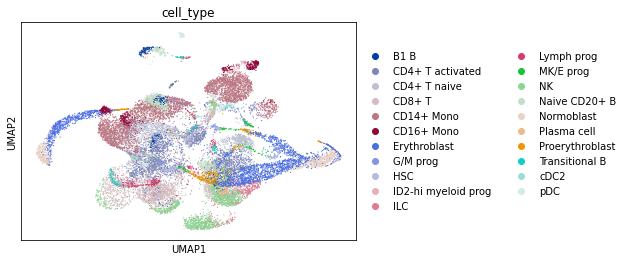

In [75]:
sc.tl.umap(true_adata)
sc.pl.umap(true_adata, color=['cell_type'])